In [19]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest
import arviz as az
import numpyro.distributions as dist
import corner
from joblib import Parallel, delayed
from tqdm import tqdm


sys.path.insert(0, '..')
from roxy import regressor, plotting

---

# Helper Functions

In [12]:
params = ['A', 'B', 'mu_gauss', 'sig', 'w_gauss']

In [13]:

###############################################################################################################################
## HELPER METHODS

def dict_samples_to_array(samples):
    """Convert a dictionary of samples to a 2-dimensional array."""
    data = []
    names = []

    for key, x in samples.items():
        if x.ndim == 1:
            data.append(x)
            names.append(key)
        elif x.ndim == 2:
            for i in range(x.shape[-1]):
                data.append(x[:, i])
                names.append(f"{key}_{i}")
        elif x.ndim == 3:
            for i in range(x.shape[-1]):
                for j in range(x.shape[-2]):
                    data.append(x[:, j, i])
                    names.append(f"{key}_{j}_{i}")
        else:
            raise ValueError("Invalid dimensionality of samples to stack.")

    return np.vstack(data).T, names




def plot_posterior_diagnostics(samples, truth):
    """
    samples: array of shape [n_runs, n_samples, n_params]
    truth:   array of shape [n_runs, n_params]
    """

    n_runs, n_samples, n_params = samples.shape

    # Preallocate diagnostics
    z_scores = np.zeros((n_runs, n_params))
    pit_vals = np.zeros((n_runs, n_params))

    # Compute metrics for each run + parameter
    for r in range(n_runs):
        for p in range(n_params):
            post = samples[r, :, p]
            t = truth[r, p]

            mu = np.mean(post)
            sigma = np.std(post)

            # Z-score: (mean - truth)/std
            z_scores[r, p] = (mu - t) / sigma

            # PIT value: posterior CDF evaluated at truth
            pit_vals[r, p] = np.mean(post <= t)

    # ---- Plotting ----
    fig, axes = plt.subplots(3, n_params, figsize=(4*n_params, 10))

    for p in range(n_params):

        # ----- Row 1: Standardised error histogram -----
        ax = axes[0, p]
        ax.hist(z_scores[:, p], bins=20, density=True, alpha=0.7)
        ax.set_title(f"Param {p+1}: (mean - truth)/std")
        ax.axvline(0, color="black", linestyle="--", linewidth=1)

        # ----- Row 2: PIT histogram -----
        ax = axes[1, p]
        ax.hist(pit_vals[:, p], bins=20, range=(0, 1), density=True, alpha=0.7)
        ax.plot([0, 1], [1, 1], "k--", linewidth=1)
        ax.set_title(f"Param {p+1}: PIT histogram")
        ax.set_xlim(0, 1)

        # ----- Row 3: PIT CDF + envelope + KS test -----
        ax = axes[2, p]
        sorted_pit = np.sort(pit_vals[:, p])
        cdf = np.linspace(0, 1, n_runs)

        # KS test
        ks_stat, ks_p = kstest(pit_vals[:, p], "uniform")

        # 95% uniform envelope
        lo = np.maximum(0, cdf - 1.36/np.sqrt(n_runs))    # KS 95% envelope
        hi = np.minimum(1, cdf + 1.36/np.sqrt(n_runs))

        ax.plot(sorted_pit, cdf, label="Empirical CDF")
        ax.plot([0,1],[0,1],"k--",label="Ideal CDF")

        ax.fill_between(sorted_pit, lo, hi, color="gray", alpha=0.3,
                        label="95% KS envelope")

        ax.set_title(f"Param {p+1}: PIT CDF (KS={ks_stat:.3f}, p={ks_p:.3f})")
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)

    fig.tight_layout()
    return fig





###############################################################################################################################
## GENERATE SYNTHETIC DATA



def convert_Fr(Fr_mJy, Fr_mJy_unc, d_kpc, d_kpc_unc, nu_GHz=1.28):
    """
    Convert radio flux density in units of mJy to radio luminosity in units of erg/s. Also returns error -- assuming nu has no uncertainty
    """

    S = Fr_mJy * 1e-3 * 1e-23         # convert mJy to Jy, then Jy to erg s^-1 cm^-2 Hz^-1
    d = d_kpc * 1e3 * 3.086e18       # convert kpc to cm
    nu = nu_GHz * 1e9                # convert GHz to Hz

    # Calculate luminosity
    L = 4 * np.pi * d**2 * S * nu    # in erg/s
    L_unc = L*np.sqrt( (Fr_mJy_unc/Fr_mJy)**2 + (2* d_kpc_unc/d_kpc)**2)

    return L, L_unc


################


def gen_synthetic_data(seed=0, return_alt=False, nx=None, verbose=True, no_uplims=False, change_line=False):

    # Set the seed for generating xtrue, xobs, ytrue, yobs values
    # Note that I also use the seed for generating xtrue and ytrue because we have a small number of data points, 
    # and if we don't, it will bias mu_gauss values across all repeats towards xtrue instead of of mu_true, 
    # and will bias w_gauss across all repeats towards the std of xtrue instead of w_true
    np.random.seed(seed)
    rng = np.random.default_rng(seed)

    #####################

    ## READ IN THE DATA
    path = "interpolated_lrlx.txt"
    df = pd.read_csv(path, sep=',', header=0, encoding='utf-8')

    ## Get the BH HS/QS data, ignoring Lx upper limits
    mask = (df['class'].isin(["BH", "candidateBH"]) & (df['state'].isin(["HS", "QS"]))  & (df["Lx_uplim_bool"]==0) )
    filtered_df = df[mask] 
    D_kpc =  filtered_df['D'].to_numpy() # distance in kpc for each data point
    Lx = filtered_df['Lx'].to_numpy()
    Lx_unc_l = filtered_df['Lx_unc_l'].to_numpy()
    Lx_unc_u = filtered_df['Lx_unc_u'].to_numpy()
    Lx_uplims = filtered_df['Lx_uplim_bool'].astype(bool)
    Lr = filtered_df['Lr'].to_numpy()
    Lr_unc_l = filtered_df['Lr_unc'].to_numpy()     
    Lr_uplims = filtered_df['Lr_uplim_bool'].astype(bool)
    Lr_unc_u = np.copy(Lr_unc_l)
    Lr_unc_u[Lr_uplims] = 0
    
    
    ## Make a detection threshold of 3*rms where rms ~20uJy, using D_kpc
    rms = 20e-6 # Jy
    rms_erg_s, _ = convert_Fr(rms*1e3, 0, D_kpc, 0, nu_GHz=1.28) # erg/s
    threshold_Lr = 3 * np.array(rms_erg_s)

    #####################

    ## LINE PARAMETERS
    Lx0 = 5.21e35
    Lr0 = 5.14e28

    if change_line:
        beta = np.random.uniform(-2, 2) # slope
        norm_log = np.random.uniform(-2, 2) # intercept in log space
        sigma_eps_log = np.random.uniform(0.01, 2) # scatter in log space

        min_x = np.min(np.log10(Lx/Lx0))
        max_x = np.max(np.log10(Lx/Lx0))
        mu_true = np.random.uniform(1.1*min_x, 0.9*max_x) # mean of x distribution
        w_true = np.random.uniform(0, 0.9*(max_x - min_x)) # std of x distribution

    else:
        beta = 0.612
        norm_log = 0.12 # normalisation in log space, for linear fit
        sigma_eps_log = 0.5 # intrinsic scatter in log space, for linear fit
        
        xtrue_ref = np.log10(Lx/Lx0)
        mu_true = np.mean(xtrue_ref)
        w_true = np.std(xtrue_ref, ddof=1)

    # Normalisation in linear space, for powerlaw fit
    alpha = 10**norm_log # = (Lr0/(Lx0)**beta) * 10**(norm_log)

    if verbose:
        print("Line parameters:")
        print("beta (slope):", beta)
        print("norm_log (intercept):", norm_log)
        print("sigma_eps_log (scatter):", sigma_eps_log)
        print("mu_true (mean of x distribution):", mu_true)
        print("w_true (std of x distribution):", w_true)


    #####################

    ## MAKE SAMPLE DATA 
    # Generate sample data in log space directly

    ## Generate xtrue values 
    xerr = np.random.uniform(0.1/np.log(10), 0.5/np.log(10), size=xtrue_ref.shape)  # errors in log space are 1/log(10) * dx_lin/x_lin, so this corresponds to ~10-50% errors in linear space
    # Draw xtrue from a Gaussian with mean mu_true and standard deviation w_true
    xtrue = np.random.normal(mu_true, w_true, size=len(xtrue_ref)) 
    # Add the measurement error
    xobs = xtrue + np.random.normal(size=len(xtrue)) * xerr

    ## Generate ytrue values, using the xtrue values generated above
    # Log space, i.e. for the linear fit
    ymean = norm_log + beta * xtrue # using the line parameters
    # Add intrinsic scatter
    ytrue = ymean + np.random.normal(size=len(ymean))* sigma_eps_log
    yerr = np.random.uniform(0.05/np.log(10), 0.4/np.log(10), size=xtrue.shape)   # errors in log space are 1/log(10) * dx_lin/x_lin, so this corresponds to ~5-40% errors in linear space
    # Add the measurement error
    yobs = ytrue + np.random.normal(size=len(xtrue)) * yerr
    yobs_orig = np.copy(yobs)


    ## Upper limits
    # Do this in linear space -- just easier / more intuitive in terms of understanding the <3*rms rule
    if no_uplims==False:
        
        ytrue_lin = 10**ytrue # = Lr / Lr0
        yobs_lin = 10**yobs # = Lr_obs / Lr0
        yerr_lin = ytrue_lin * np.log(10)* yerr  # = Lr_unc / Lr0 ; convert to linear space, just using small-ish error approximation... should be between 5-40%
        # Apply 3*rms rule for upper limits
        uplims_obs = (yobs_lin< threshold_Lr/Lr0) # mask
        yobs[uplims_obs] = np.log10(threshold_Lr[uplims_obs]/Lr0) # set the observed value to the threshold in log space
        
        if verbose: # Check 
            test = yerr_lin / ytrue_lin  *100   # should be between 5-40%
            plt.hist(test, bins=10)
            plt.xlabel("y-value % errors in linear space")
            plt.show()
    
    else: 
        uplims_obs = np.zeros(len(yobs), dtype=bool)


    ## Subsample if needed
    if nx is not None:
        indx = rng.choice(len(xobs), size=nx, replace=False)
        xtrue = xtrue[indx]
        xobs = xobs[indx]
        xerr = xerr[indx]
        ytrue = ytrue[indx]
        yobs = yobs[indx]
        yerr = yerr[indx]
        uplims_obs = uplims_obs[indx]
        yobs_orig = yobs_orig[indx]
        
    
    #####################

    ## PLOTTING

    ## Show the generated data
    if verbose:

        print("Number of data points in the txt file: ", len(Lx))
        print("Number of data points used: ", len(xtrue))
        print("Number of uplims: ", sum(uplims_obs))


        x_plot = np.logspace(np.log10(min(Lx/Lx0)), np.log10(max(Lx/Lx0)), 1000)
        x_plot_lin = np.log10(x_plot)

        
        #plt.errorbar(xobs, yobs, xerr=xerr, yerr=yerr, uplims = uplims_obs, fmt='o', label='Observed Data', color='blue')
        #plt.errorbar(xobs, yobs_orig, uplims = uplims_obs, fmt='o', label='Observed Data', color='green', ms=3)
        #x_plot_lin = np.log10(x_plot)
        #y_fit = np.log10(alpha) + beta * x_plot_lin
        #plt.plot( x_plot_lin  , y_fit, color='red' , label='True line')
        #plt.xlabel(r'$\log(L_X / L_{X0})$', fontsize=14)
        #plt.ylabel(r'$\log(L_R / L_{R0})$', fontsize=14)
        #plt.legend()
        #plt.show()
 

        print("True line: y = {:.4f}x + {:.4f}, sigma = {:.4f}".format(beta, norm_log, sigma_eps_log))

        ## Plot the true line
        x_plot_lin = np.log10(x_plot)
        y_fit = np.log10(alpha) + beta * x_plot_lin
        plt.plot( x_plot_lin  , y_fit, color='red' , label='True line')
        ## Plot the true observed data (if there are no detection limits)
        plt.errorbar(xobs, yobs_orig, uplims = uplims_obs, fmt='o', label='True Observed Data', color='green', ms=2)
        ## Plot the observed data, after accounting for detection limits
        plt.errorbar(xobs[~uplims_obs], yobs[~uplims_obs], xerr=xerr[~uplims_obs], yerr=yerr[~uplims_obs], fmt='o', label='Observed Data', color='blue')
        plt.errorbar(xobs[uplims_obs], yobs[uplims_obs], xerr=xerr[uplims_obs], yerr=yerr[uplims_obs], uplims= np.ones(sum(uplims_obs), dtype= bool), fmt='o', label='Upper Limits', color='orange')
        ## Plot settings
        plt.xlabel(r'$\log(L_X / L_{X0})$', fontsize=14)
        plt.ylabel(r'$\log(L_R / L_{R0})$', fontsize=14)
        plt.legend()
        plt.show()

        ## Histograms of true y values
        plt.hist(ytrue[~uplims_obs], alpha=0.5, label='ytrue detections', color='blue', density=True)
        plt.hist(ytrue[uplims_obs], alpha=0.5, label='ytrue uplims', color='orange', density=True)
        plt.xlabel("ytrue values")
        plt.legend()    
        plt.show()

        ## Histograms of true x values
        plt.hist(xtrue)
        plt.xlabel("xtrue values")
        plt.show()
        print("True mu (i.e. mean x_true):", mu_true)
        print("True w (i.e. std of x_true):", w_true)
        

    #####################

    ## PREPARE OUTPUTS

    ## Prepare array of the true values
    true_vals = [beta, norm_log, mu_true, sigma_eps_log, w_true] # [slope_true, offset_true, mu_true, sig_true, w_true]

    ## Separate detections and upper limits
    delta = np.ones(len(xobs), dtype=bool)  # 1 for detection, 0 for upper limit
    delta[uplims_obs] = False
    xdet = xobs[delta]  
    ydet = yobs[delta]
    xdet_err = xerr[delta]
    ydet_err = yerr[delta]
    xuplim = xobs[~delta]
    yuplim = yobs[~delta]
    xuplim_err = xerr[~delta]
    yuplim_err = yerr[~delta]

    if return_alt: 
        delta = delta.astype(int)
        return xobs, xerr, yobs, yerr , delta, true_vals

    else: return xdet, ydet, xdet_err, ydet_err, xuplim, yuplim, xuplim_err, yuplim_err , true_vals

In [14]:
def my_fun(x, theta):
    return theta[0] * x + theta[1]

# Slope, intercept
param_names = ['A', 'B']
theta0 = [2, 0.5]
param_prior = {'A':[0, 5], 'B':[-2, 2], 'sig':[0, 3.0]}

In [15]:
###############################################################################################################################
## RUNNER FUNCTIONS


def run_single(seed=0, nx=None, verbose=False, ignore_uplims=False, nwarm=700, nsamp=5000):
    
    xobs, xerr, yobs, yerr , delta, true_vals = gen_synthetic_data(seed=seed, return_alt=True, nx=nx, verbose=verbose, no_uplims=ignore_uplims)
    delta = delta.astype(bool)

    reg = regressor.RoxyRegressor(my_fun, param_names, theta0, param_prior) 
    samples_arr = reg.mcmc(param_names, xobs, yobs, [xerr, yerr],  nwarm, nsamp, y_is_detected= delta, method='mnr', verbose=verbose)

    samples_arr, names = dict_samples_to_array(samples_arr)

    return samples_arr



def runner_with_uplims(nrepeats, nx=100, parallel=False, start_i=0,  verbose=False):
    """
    Note that the true parameters stay the same with each repeat.
    """
     
    print("Show results of each iteration:", verbose)

    func = run_single

    if parallel:
        samples_arr = Parallel(n_jobs=-1)(
            delayed(func)(start_i + i, nx, verbose=False)
            for i in tqdm(range(nrepeats))
        )
        all_samples_arr = np.stack(samples_arr, axis=0)
        
    else:
        all_samples_arr = []
        for i in range(nrepeats):
            print(f"RUN #{i}")

            samples_arr = func(start_i + i, nx, verbose=verbose )
            all_samples_arr.append(samples_arr)


    all_samples_arr = np.asarray(all_samples_arr)
    n_runs, n_samples, n_params = all_samples_arr.shape
    print("n_runs:", n_runs, "n_samples:", n_samples, "n_params:", n_params)


    # Get the true values
    _, _, _, _, _, _, _, _, true_vals = gen_synthetic_data(seed=0, nx=nx, verbose=False) # truth is the same no matter the seed
    truth = np.array([list(true_vals)]*n_runs)
    slope_true, offset_true, mu_true, sig_true, w_true = true_vals 
    truths = [slope_true, offset_true, mu_true, sig_true, w_true]
    params_ = params
    
    
    ## Check plots
    plot_posterior_diagnostics(all_samples_arr, truth)

    # Plot diagnostics
    # all_samples_arr has shape (n_runs, n_samples, n_params)
    samples_for_corner = np.vstack(all_samples_arr)  # stacks along the first axis, so resultant shape: (n_runs * n_samples, n_params)
    fig = corner.corner(samples_for_corner, labels=params_, truths=truths)
    plt.show()


---

# Generate the Synthetic Data

Line parameters:
beta (slope): 0.612
norm_log (intercept): 0.12
sigma_eps_log (scatter): 0.5
mu_true (mean of x distribution): -0.26104341131270686
w_true (std of x distribution): 1.3957061360744607


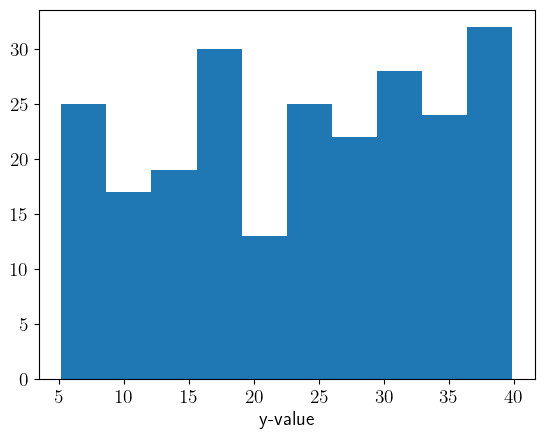

Number of data points in the txt file:  235
Number of data points used:  235
Number of uplims:  50
True line: y = 0.6120x + 0.1200, sigma = 0.5000


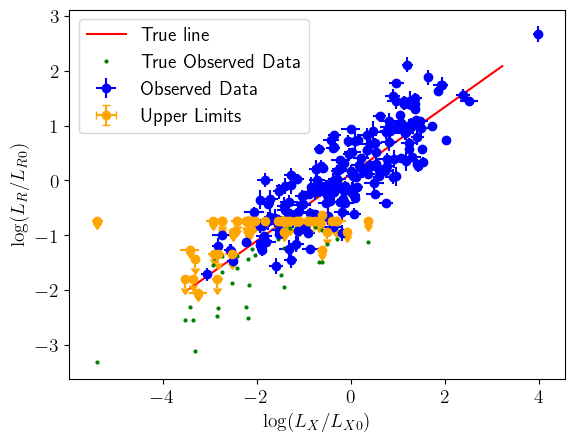

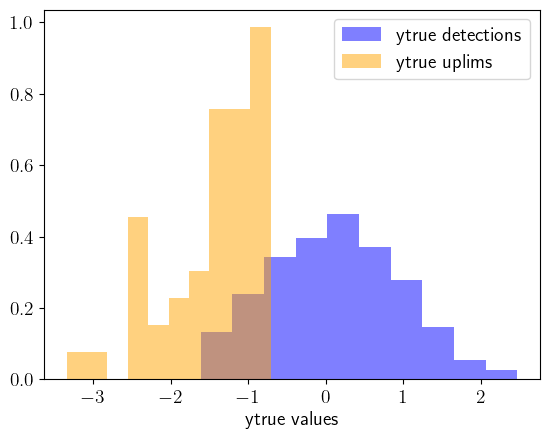

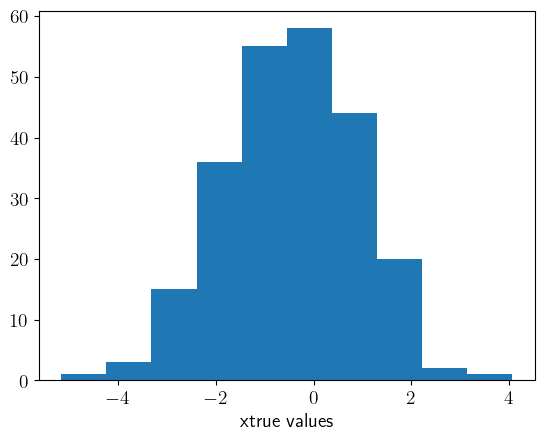

True mu (i.e. mean x_true): -0.26104341131270686
True w (i.e. std of x_true): 1.3957061360744607


In [20]:
xobs, xerr, yobs, yerr , delta, true_vals = gen_synthetic_data(seed=0, return_alt=True, verbose=True, no_uplims=False)
delta = delta.astype(bool)

# One Run


Optimisation Results:
A:	0.6574254631996155
B:	0.10055039077997208
sig:	0.4654250144958496
mu_gauss:	-0.4736078679561615
w_gauss:	1.3751791715621948

Optimisation Results:
A:	0.4399636387825012
B:	0.04450901225209236
sig:	2.2336068153381348
mu_gauss:	-0.4739454388618469
w_gauss:	1.3636914491653442

Running MCMC


sample: 100%|██████████| 5700/5700 [00:09<00:00, 601.10it/s, 7 steps of size 6.57e-01. acc. prob=0.92]



                mean       std    median      2.5%     97.5%     n_eff     r_hat
         A      0.66      0.03      0.66      0.60      0.71   5873.00      1.00
         B      0.10      0.04      0.10      0.03      0.17   6841.50      1.00
  mu_gauss     -0.47      0.09     -0.47     -0.65     -0.30   6589.05      1.00
       sig      0.47      0.03      0.47      0.42      0.53   6421.10      1.00
   w_gauss      1.39      0.07      1.38      1.26      1.51   6308.23      1.00

Number of divergences: 0


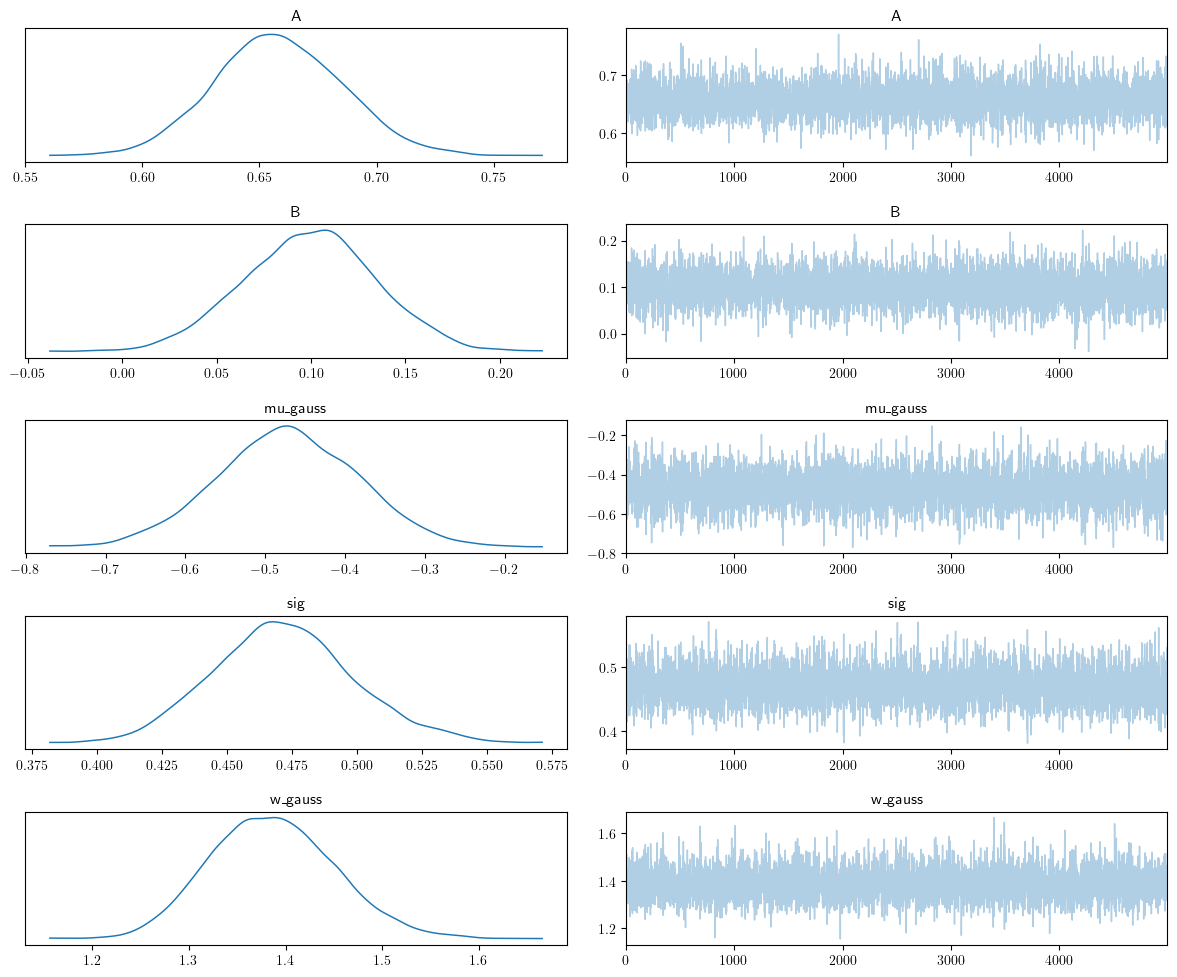

Removed no burn in


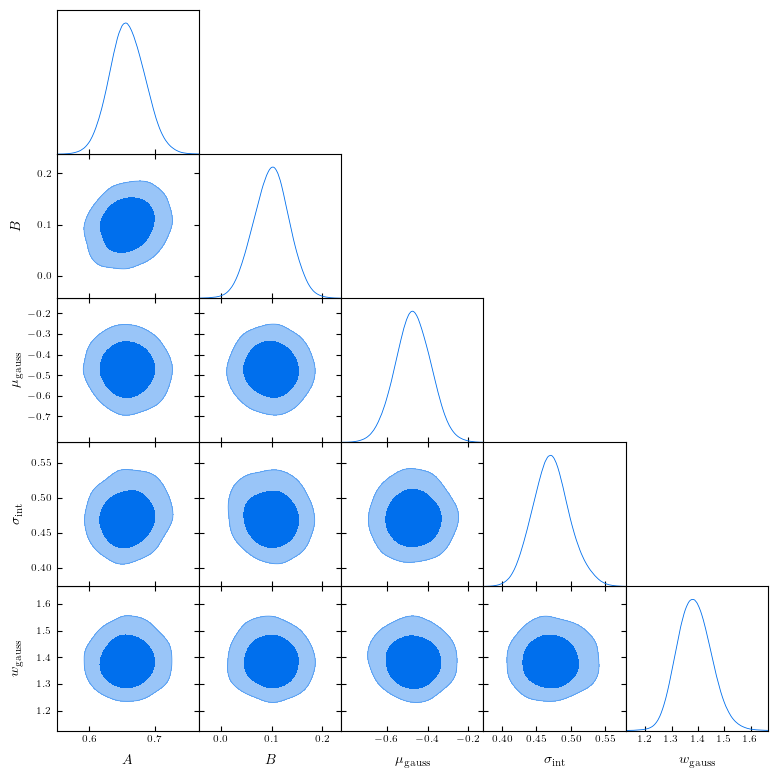

In [21]:
reg = regressor.RoxyRegressor(my_fun, param_names, theta0, param_prior)

res, all_param_names = reg.optimise(param_names, xobs, yobs, [xerr, yerr], y_is_detected= delta, method='mnr')

nwarm, nsamp = 700, 5000
samples = reg.mcmc(param_names, xobs, yobs, [xerr, yerr],  nwarm, nsamp, y_is_detected= delta, method='mnr')

plotting.trace_plot(samples, to_plot='all')
plotting.triangle_plot(samples, to_plot='all', module='getdist', param_prior=param_prior)

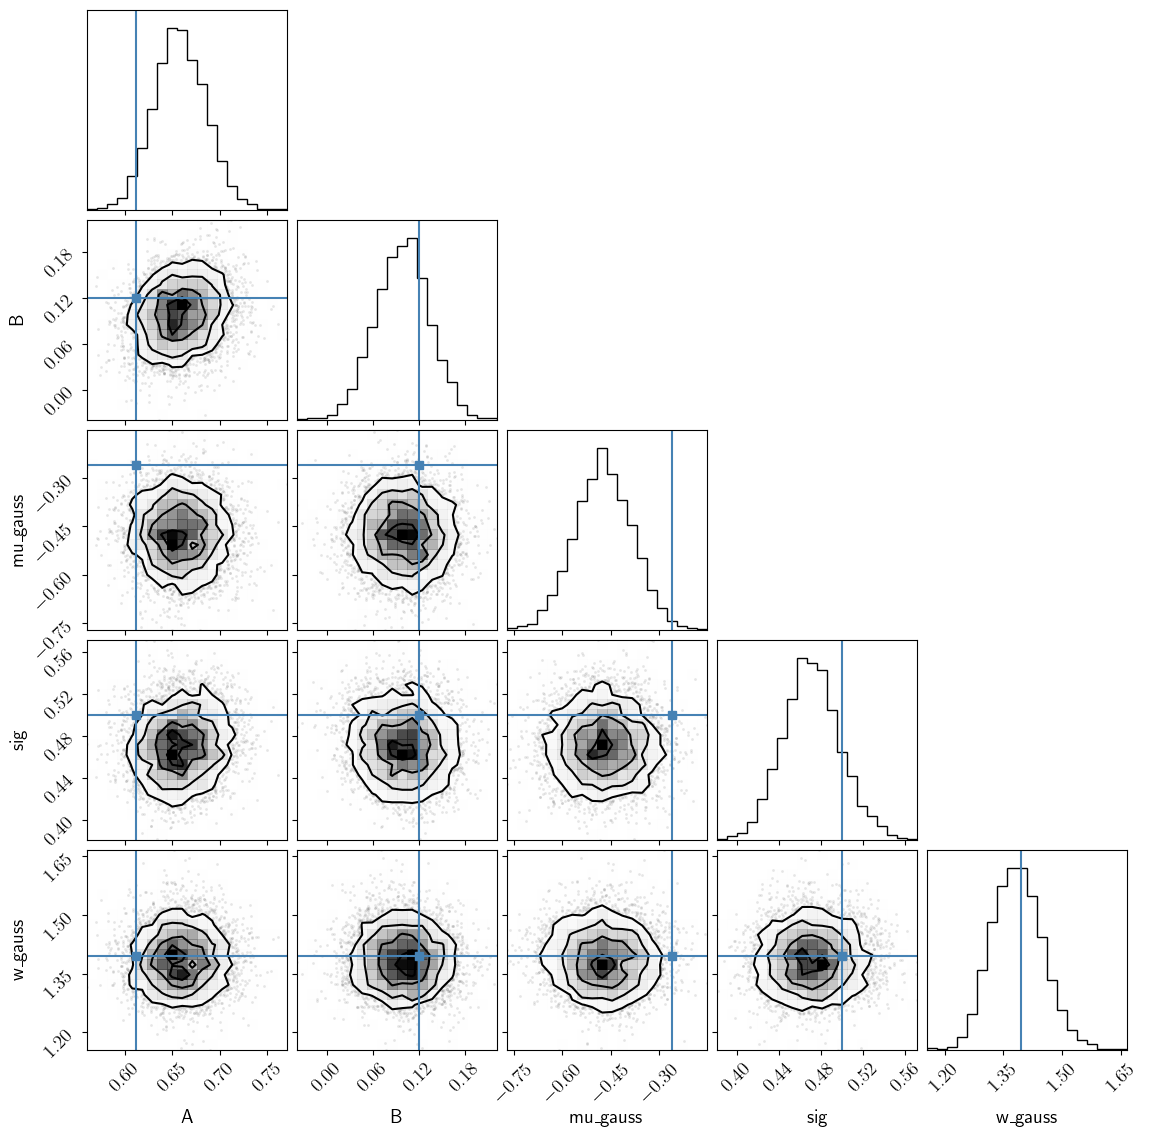

In [22]:
# Get the true vals
_, _, _, _, _, _, _, _, true_vals = gen_synthetic_data(seed=0, nx=None, verbose=False) # truth is the same no matter the seed
slope_true, offset_true, mu_true, sig_true, w_true = true_vals 

# Plot a corner plot
samples_arr, names = dict_samples_to_array(samples)
fig = corner.corner(samples_arr, labels=params, truths=[slope_true, offset_true, mu_true, sig_true, w_true])
plt.show()

Line parameters:
beta (slope): 0.612
norm_log (intercept): 0.12
sigma_eps_log (scatter): 0.5
mu_true (mean of x distribution): -0.26104341131270686
w_true (std of x distribution): 1.3957061360744607


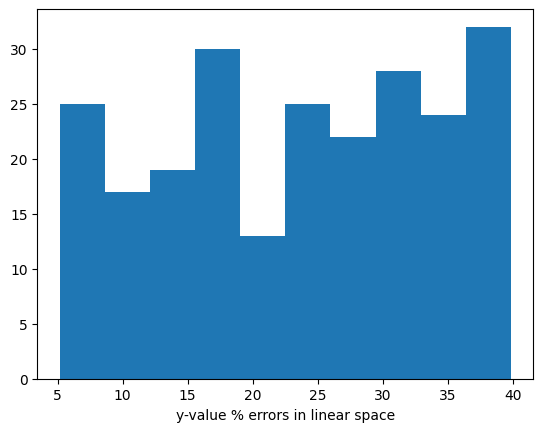

Number of data points in the txt file:  235
Number of data points used:  235
Number of uplims:  50
True line: y = 0.6120x + 0.1200, sigma = 0.5000


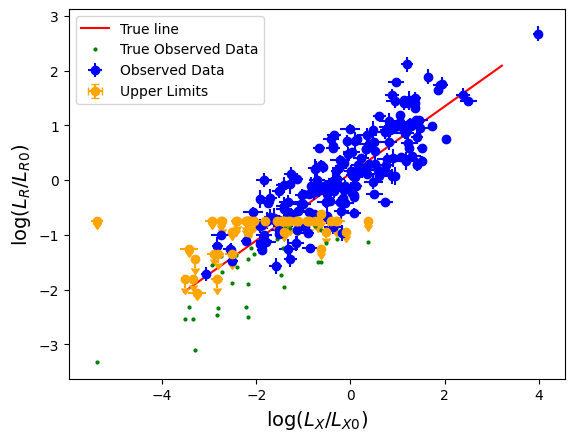

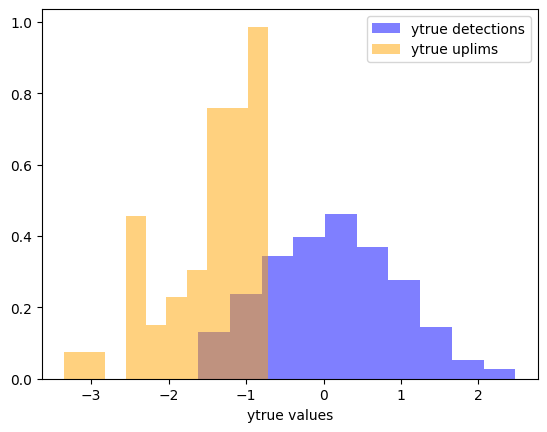

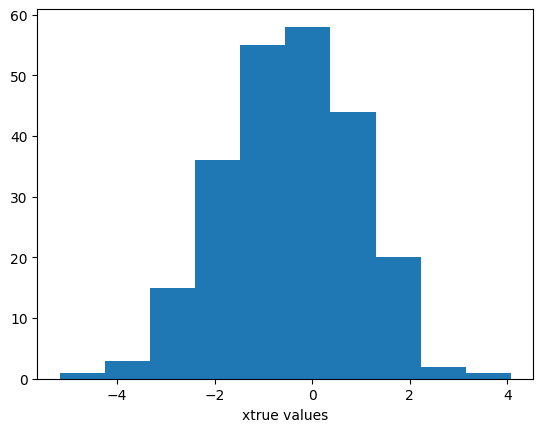

True mu (i.e. mean x_true): -0.26104341131270686
True w (i.e. std of x_true): 1.3957061360744607

Optimisation Results:
A:	0.8507558703422546
B:	-0.13880471885204315
sig:	0.48678916692733765
mu_gauss:	-0.8472095131874084
w_gauss:	-1.341776728630066

Running MCMC


/mnt/users/crookmansourj/ROXY/roxy/tests/../roxy/regressor.py:740: UserWarning: Site w_gauss: Out-of-support values provided to log prob method. The value argument should be within the support.
  sampler.run(rng_key_)



Could not init to optimised values

Running MCMC


sample: 100%|██████████| 5700/5700 [00:09<00:00, 611.88it/s, 7 steps of size 7.17e-01. acc. prob=0.90]


                mean       std    median      2.5%     97.5%     n_eff     r_hat
         A      0.66      0.03      0.66      0.60      0.71   5814.32      1.00
         B      0.10      0.03      0.10      0.03      0.17   5968.56      1.00
  mu_gauss     -0.47      0.09     -0.47     -0.64     -0.29   5672.31      1.00
       sig      0.47      0.03      0.47      0.42      0.53   5182.79      1.00
   w_gauss      1.38      0.06      1.38      1.26      1.51   5893.82      1.00

Number of divergences: 0
(5000, 5)


In [10]:
# Test the runner function
samples = run_single(verbose=True)
print(samples.shape)

# Many Runs

Show results of each iteration: False


warmup:   8%|▊         | 472/5700 [00:03<00:12, 428.47it/s, 7 steps of size 8.44e-01. acc. prob=0.79]/mnt/users/crookmansourj/ROXY/roxy/tests/../roxy/regressor.py:740: UserWarning: Site w_gauss: Out-of-support values provided to log prob method. The value argument should be within the support.
  sampler.run(rng_key_)
warmup:   8%|▊         | 434/5700 [00:03<00:17, 305.44it/s, 3 steps of size 8.00e-01. acc. prob=0.79]/mnt/users/crookmansourj/ROXY/roxy/tests/../roxy/regressor.py:740: UserWarning: Site w_gauss: Out-of-support values provided to log prob method. The value argument should be within the support.
  sampler.run(rng_key_)
sample:  26%|██▋       | 1507/5700 [00:04<00:05, 826.80it/s, 3 steps of size 8.02e-01. acc. prob=0.90]/mnt/users/crookmansourj/ROXY/roxy/tests/../roxy/regressor.py:740: UserWarning: Site w_gauss: Out-of-support values provided to log prob method. The value argument should be within the support.
  sampler.run(rng_key_)
warmup:   4%|▍         | 221/5700 [00:03<0

n_runs: 100 n_samples: 5000 n_params: 5


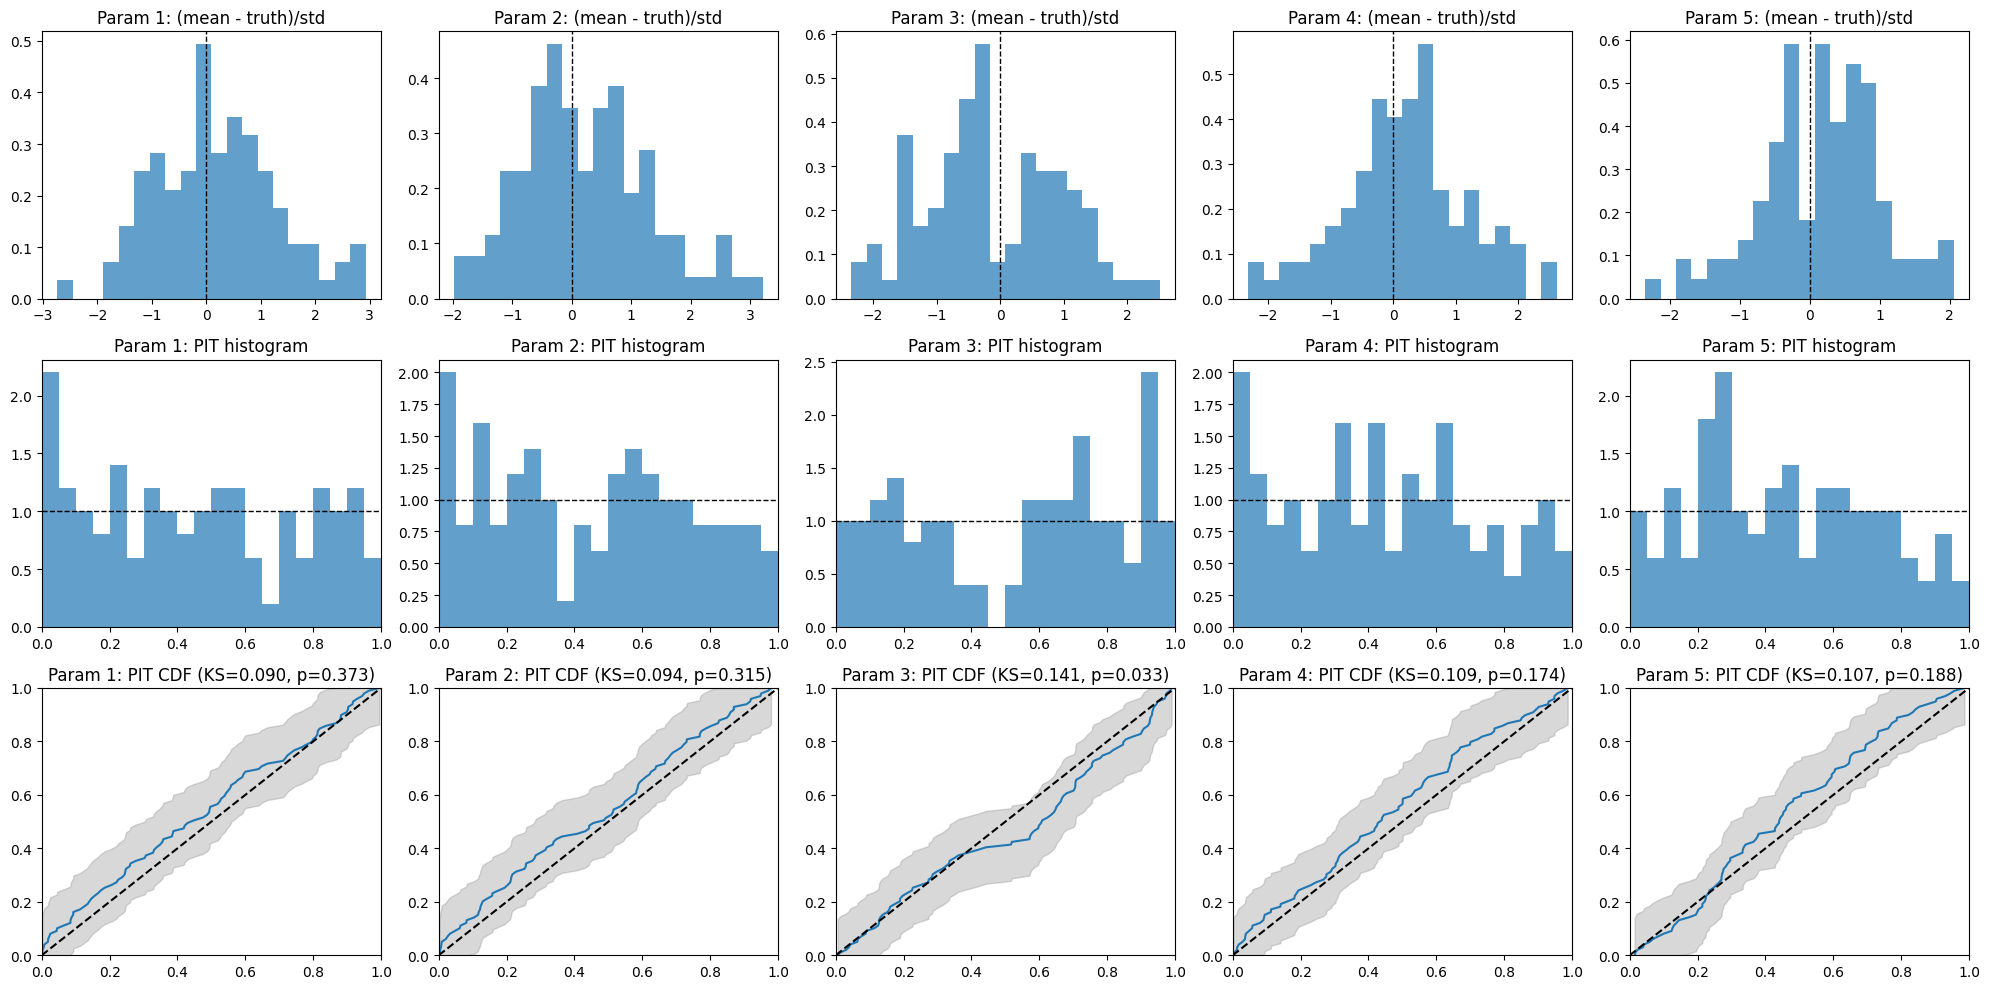

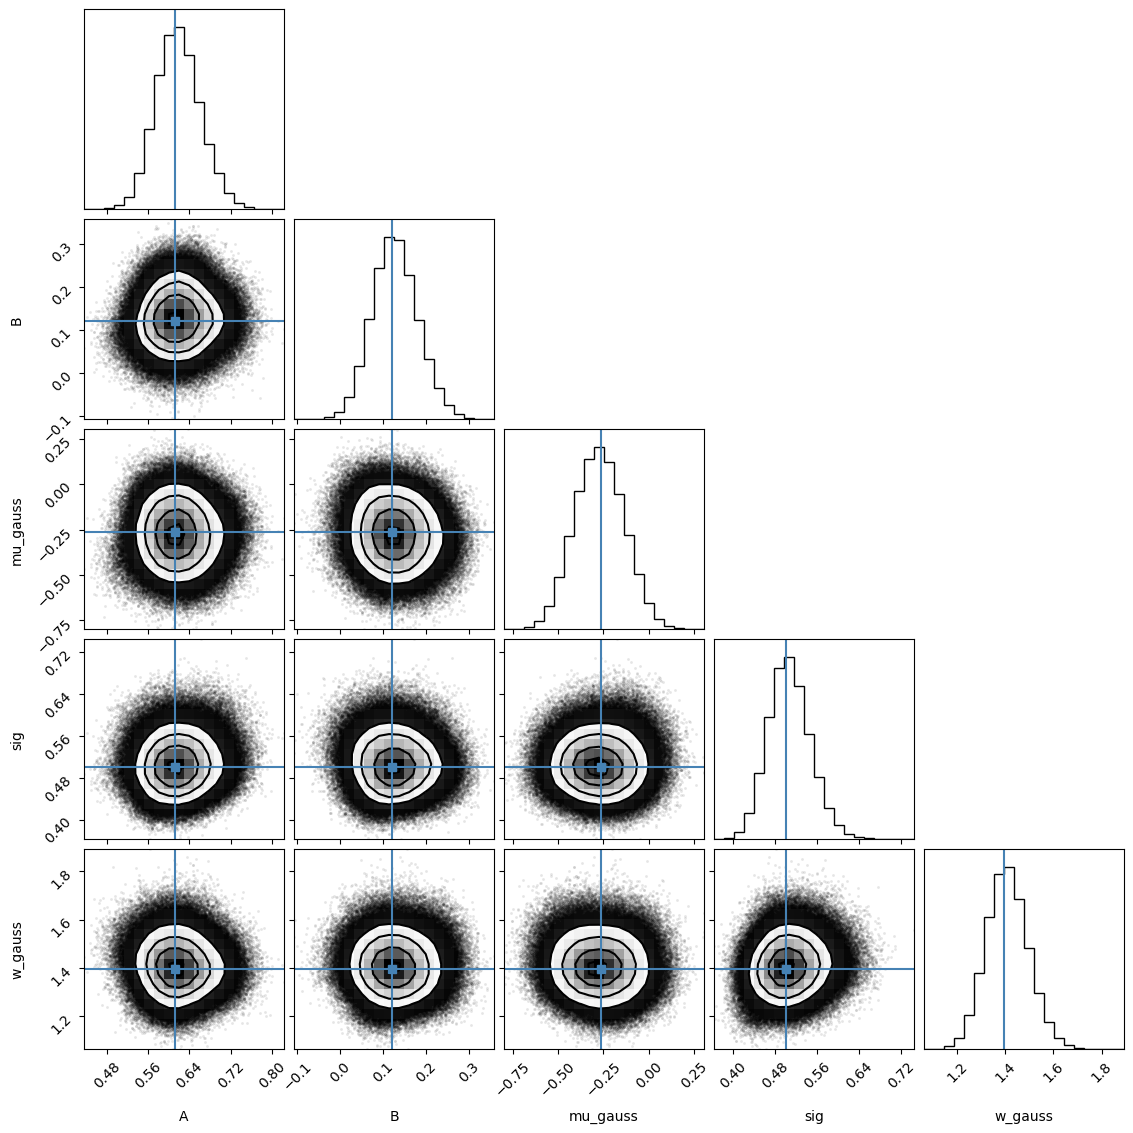

In [16]:
runner_with_uplims(nrepeats=100, nx=None, parallel=True, start_i=0,  verbose=False)

---

# Try with a smaller number of data points

Line parameters:
beta (slope): 0.612
norm_log (intercept): 0.12
sigma_eps_log (scatter): 0.5
mu_true (mean of x distribution): -0.26104341131270686
w_true (std of x distribution): 1.3957061360744607


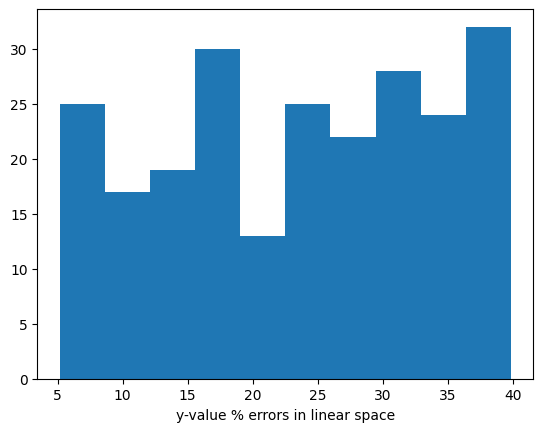

Number of data points in the txt file:  235
Number of data points used:  30
Number of uplims:  8
True line: y = 0.6120x + 0.1200, sigma = 0.5000


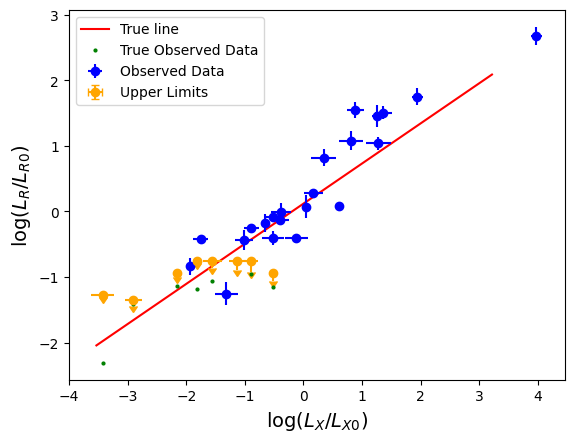

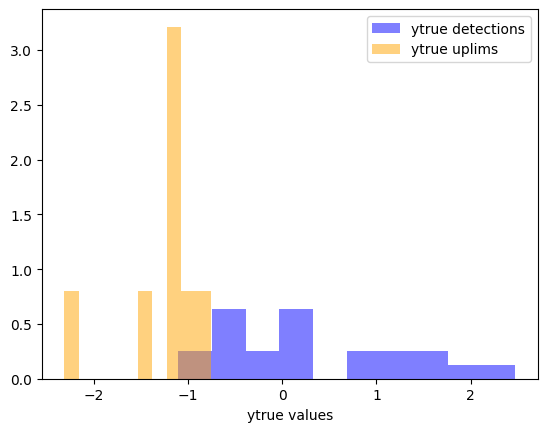

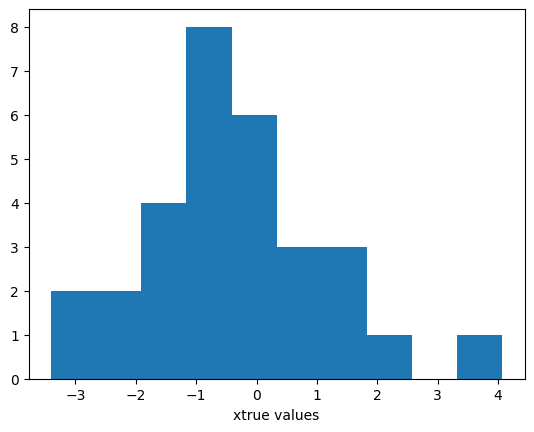

True mu (i.e. mean x_true): -0.26104341131270686
True w (i.e. std of x_true): 1.3957061360744607


In [ ]:
xobs, xerr, yobs, yerr , delta, true_vals = gen_synthetic_data(seed=0, nx=30, return_alt=True, verbose=True, no_uplims=False)
delta = delta.astype(bool)
delta

# One Run

In [12]:
reg = regressor.RoxyRegressor(my_fun, param_names, theta0, param_prior)

res, all_param_names = reg.optimise(param_names, xobs, yobs, [xerr, yerr], y_is_detected= delta, method='mnr')

nwarm, nsamp = 700, 5000
samples = reg.mcmc(param_names, xobs, yobs, [xerr, yerr],  nwarm, nsamp, y_is_detected= delta, method='mnr')

In negloglike_mnr_uplims

Optimisation Results:
A:	0.7420562505722046
B:	0.15754714608192444
sig:	0.3741823434829712
mu_gauss:	-0.37133875489234924
w_gauss:	1.4926738739013672
In negloglike_mnr_uplims

Optimisation Results:
A:	0.6631236672401428
B:	-0.4695321321487427
sig:	1.7300574779510498
mu_gauss:	-0.37112221121788025
w_gauss:	1.4018428325653076

Running MCMC
In Likelihood_MNR_uplims
In Likelihood_MNR_uplims
In negloglike_mnr_uplims


  0%|          | 0/5700 [00:00<?, ?it/s]

In Likelihood_MNR_uplims
In negloglike_mnr_uplims


sample: 100%|██████████| 5700/5700 [00:05<00:00, 1059.11it/s, 7 steps of size 6.25e-01. acc. prob=0.93]



                mean       std    median      2.5%     97.5%     n_eff     r_hat
         A      0.75      0.07      0.75      0.61      0.88   4888.50      1.00
         B      0.15      0.09      0.15     -0.04      0.33   5317.46      1.00
  mu_gauss     -0.37      0.29     -0.37     -0.94      0.20   6021.26      1.00
       sig      0.42      0.08      0.42      0.28      0.60   4656.49      1.00
   w_gauss      1.59      0.22      1.57      1.20      2.03   5349.18      1.00

Number of divergences: 0


# Many Runs

Show results of each iteration: False


sample:  82%|████████▏ | 4668/5700 [00:05<00:00, 1511.32it/s, 7 steps of size 6.97e-01. acc. prob=0.88]/mnt/users/crookmansourj/ROXY/roxy/tests/../roxy/regressor.py:740: UserWarning: Site w_gauss: Out-of-support values provided to log prob method. The value argument should be within the support.
  sampler.run(rng_key_)
  0%|          | 0/5700 [00:00<?, ?it/s]/mnt/users/crookmansourj/ROXY/roxy/roxy_venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
  0%|          | 0/5700 [00:00<?, ?it/s]/mnt/users/crookmansourj/ROXY/roxy/tests/../roxy/regressor.py:740: UserWarning: Site w_gauss: Out-of-support values provided to log prob method. The value argument should be within the support.
  sampler.run(rng_key_)
warmup:   2%|▏         | 117/5700 [00:02<01:25, 65.06it/s, 31 steps of size 1.84e-01. acc. prob=0.7

n_runs: 100 n_samples: 5000 n_params: 5


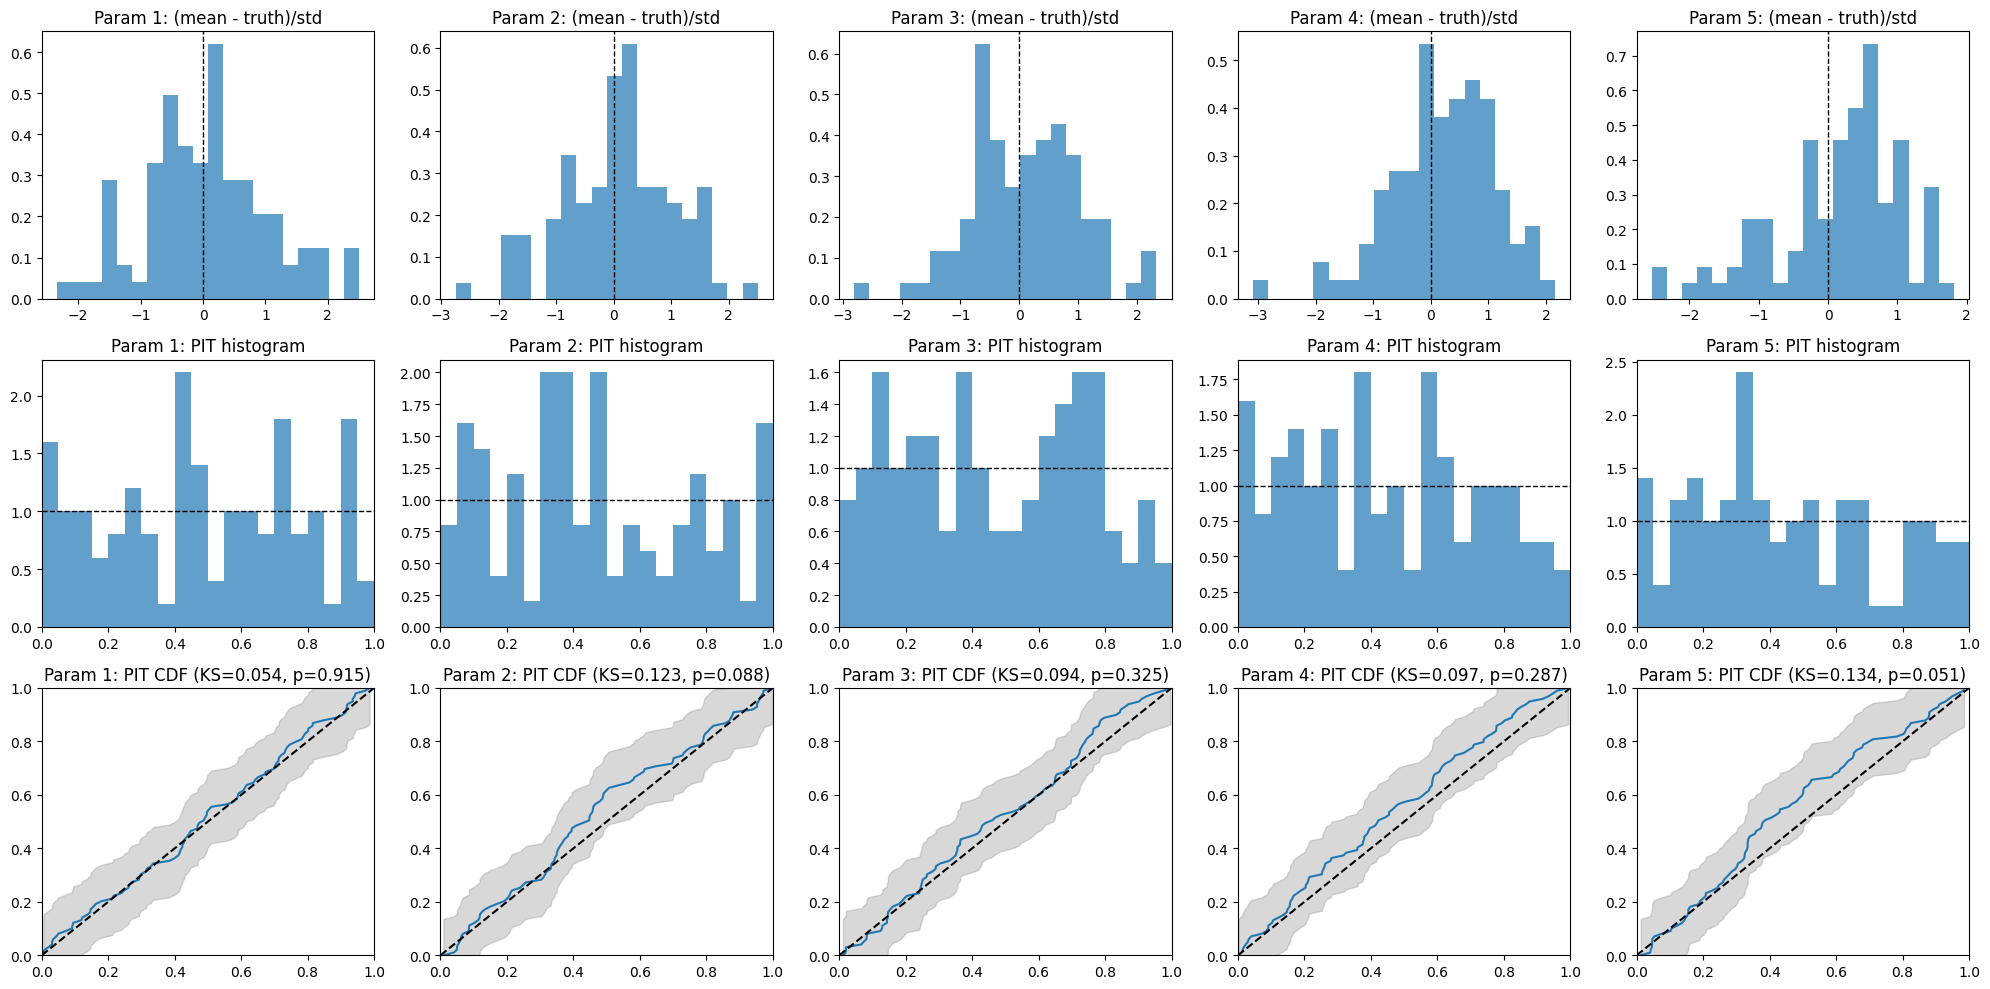

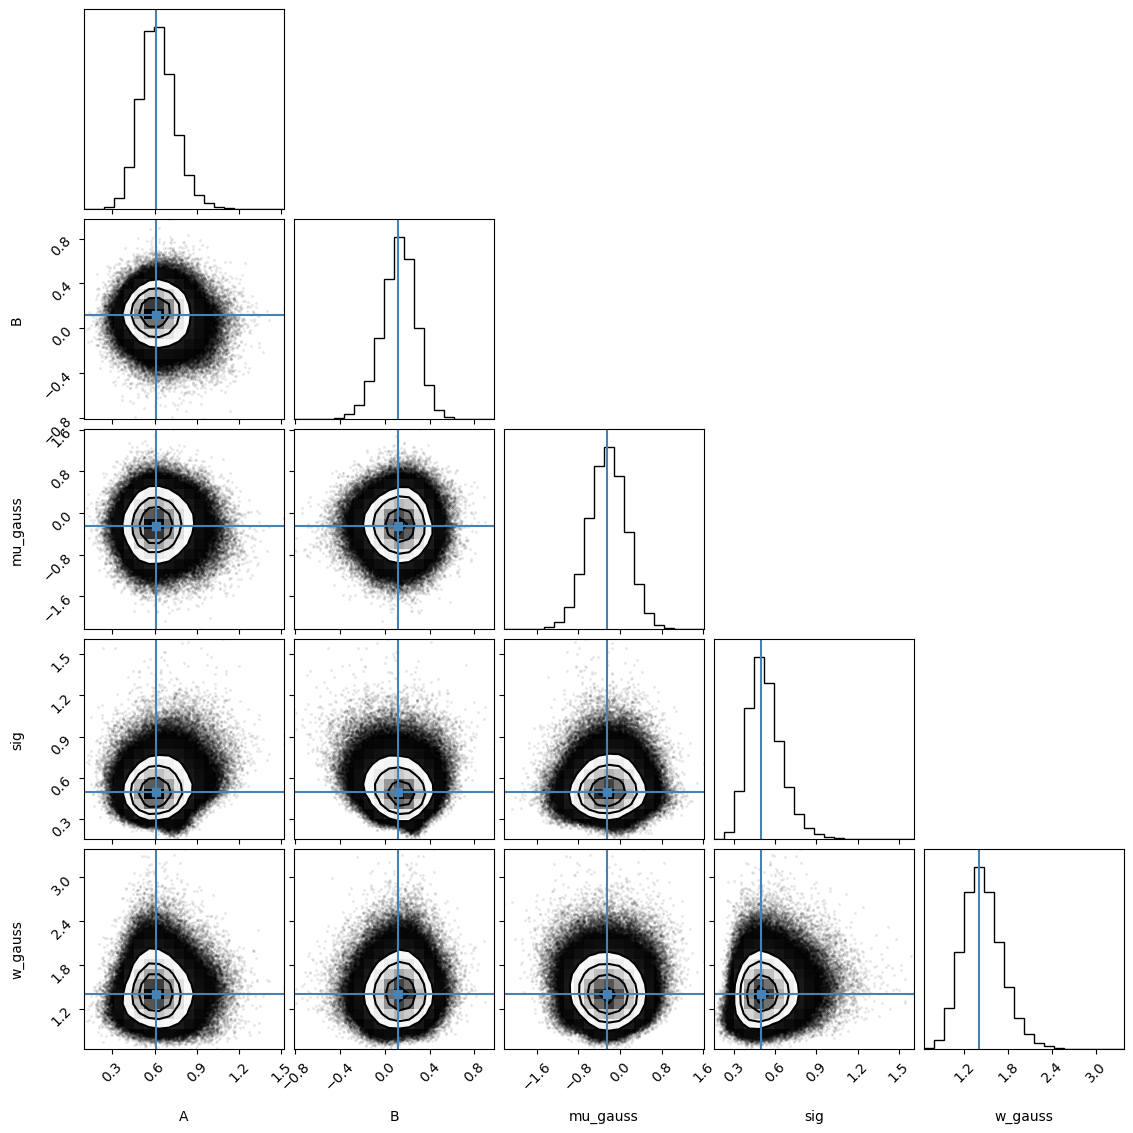

In [17]:
runner_with_uplims(nrepeats=100, nx=30, parallel=True, start_i=0,  verbose=False)